# Initialization

## Imports

In [ ]:
# general imports
import cv2
from datetime import datetime
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import re
import shutil
import zipfile
import matplotlib.image as mpimg

# google colab imports
from google.colab import drive
from google.colab import auth

# tensorflow imports
from itertools import cycle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from keras import callbacks
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

## Globals

In [ ]:
# Globals
DRIVE_MOUNT_DIR: str = '/content/drive'
PROJECT_DIR: str = os.path.join(DRIVE_MOUNT_DIR, 'MyDrive/nyu_stern/fall_2022/FDN_NTWK_MBL_SYS/Project Smile/Project Smile/project-smile')
DATA_DIR: str = os.path.join(PROJECT_DIR, 'data')
MODEL_DIR: str = os.path.join(PROJECT_DIR, 'models')

## Mount Drive

In [ ]:
drive.mount(DRIVE_MOUNT_DIR)

Mounted at /content/drive


# Data Extraction

In [ ]:
# 1. upload the training data into a "data" folder

In [ ]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
train_zip_fname: str = 'train.zip'
train_zip_fpath = os.path.join(DATA_DIR, train_zip_fname)

# extract training files from zip
zip_ref = zipfile.ZipFile(train_zip_fpath)
zip_ref.extractall('data')

In [ ]:
train_dirpath = 'data/train'
train_braces_dirpath = os.path.join(train_dirpath, 'braces')
train_no_braces_dirpath = os.path.join(train_dirpath, 'no_braces')

braces_fnames = os.listdir(train_braces_dirpath)
no_braces_fnames = os.listdir(train_no_braces_dirpath)

print(f'braces fnames: {sorted(braces_fnames)[:10]}')
print('\n')
print(f'no braces fnames: {sorted(no_braces_fnames)[:10]}')

braces fnames: ['000001.jpg', '000001_down.jpg', '000001_left.jpg', '000001_right.jpg', '000001_up.jpg', '000001_zoom.jpg', '000002.jpg', '000002_down.jpg', '000002_left.jpg', '000002_right.jpg']


no braces fnames: ['000001.jpg', '000001_down.jpg', '000001_left.jpg', '000001_right.jpg', '000001_up.jpg', '000001_zoom.jpg', '000002.jpg', '000002_down.jpg', '000002_left.jpg', '000002_right.jpg']


In [ ]:
print(f'total braces images: {len(braces_fnames)}')
print(f'total no braces images: {len(no_braces_fnames)}')

total braces images: 822
total no braces images: 822


## Split the data into training and validation

In [ ]:
# initialize random seed
random.seed(42)

In [ ]:
# ration of images to hold out for validation
holdout_ratio = 0.2

# calculate number of training and number of validation images
num_training = math.floor(len(braces_fnames) * (1 - holdout_ratio))
num_validation = len(braces_fnames) - num_training

print(f'number of training images: {num_training}')
print(f'number of validation images: {num_validation}')

number of training images: 657
number of validation images: 165


In [ ]:
# randomly sample the training images
train_braces_fnames = random.sample(braces_fnames, num_training)
train_no_braces_fnames = random.sample(no_braces_fnames, num_training)

# save the remaining images for validation
valid_braces_fnames = [fname for fname in braces_fnames if fname not in train_braces_fnames]
valid_no_braces_fnames = [fname for fname in no_braces_fnames if fname not in train_no_braces_fnames]

In [ ]:
print(f'total training braces images: {len(train_braces_fnames)}')
print(f'total validation braces images: {len(valid_braces_fnames)}')
print(f'total training no braces images: {len(train_no_braces_fnames)}')
print(f'total validation no braces images: {len(valid_no_braces_fnames)}')

total training braces images: 657
total validation braces images: 165
total training no braces images: 657
total validation no braces images: 165


In [ ]:
!mkdir data/validation

In [ ]:
!mkdir data/validation/braces

In [ ]:
!mkdir data/validation/no_braces

In [ ]:
validation_dirpath = 'data/validation'
braces_validation_dirpath = os.path.join(validation_dirpath, 'braces')
no_braces_validation_dirpath = os.path.join(validation_dirpath, 'no_braces')

In [ ]:
# move validation images to validation folder
for fname in valid_braces_fnames:
  fpath = os.path.join(train_braces_dirpath, fname)
  shutil.move(fpath, braces_validation_dirpath)

for fname in valid_no_braces_fnames:
  fpath = os.path.join(train_no_braces_dirpath, fname)
  shutil.move(fpath, no_braces_validation_dirpath)

# Data Preprocessing

In [ ]:
# calculate the image size for the braces images
braces_img_sizes = []
for fname in os.listdir(train_braces_dirpath):
  fpath = os.path.join(train_braces_dirpath, fname)

  img = cv2.imread(fpath)
  h, w, c = img.shape
  braces_img_sizes.append([fname, h, w, c])

In [ ]:
# calculate the image size for the no braces images
no_braces_img_sizes = []
for fname in os.listdir(train_no_braces_dirpath):
  fpath = os.path.join(train_no_braces_dirpath, fname)
  
  img = cv2.imread(fpath)
  h, w, c = img.shape
  no_braces_img_sizes.append([fname, h, w, c])

In [ ]:
# add image sizes to dataframes
df_braces_sizes = pd.DataFrame(data=braces_img_sizes, columns=['fname', 'height', 'width', 'channel'])
df_no_braces_sizes = pd.DataFrame(data=no_braces_img_sizes, columns=['fname', 'height', 'width', 'channel'])

In [ ]:
df_braces_sizes.describe().loc[['mean', 'min', 'max']]

,height,width,channel
mean,210.581431,381.334855,3.0
min,145.000000,297.000000,3.0
max,279.000000,517.000000,3.0


In [ ]:
df_no_braces_sizes.describe().loc[['mean', 'min', 'max']]

,height,width,channel
mean,213.414003,386.811263,3.0
min,145.000000,316.000000,3.0
max,278.000000,519.000000,3.0


In [ ]:
# set resize dimensions
resize_height = 100
resize_width = 175

resize_dim = (resize_height, resize_width)

In [ ]:
def to_grayscale(image):
  return tf.image.rgb_to_grayscale(image)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=to_grayscale)
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=to_grayscale)

In [ ]:
batch_size = 32
steps_per_epoch = len(os.listdir(train_braces_dirpath))//batch_size
validation_steps = len(os.listdir(braces_validation_dirpath))//batch_size

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dirpath,
    classes = ['braces', 'no_braces'],
    target_size=resize_dim,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = valid_datagen.flow_from_directory(
    validation_dirpath,
    classes=['braces', 'no_braces'],
    target_size=resize_dim,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 1314 images belonging to 2 classes.
Found 330 images belonging to 2 classes.


# Model Building

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model = keras.Sequential()

# Convolutional layer and maxpool layer 1
model.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(resize_height,resize_width,3)))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 2
model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 3
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 4
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# This layer flattens the resulting image array to 1D array
model.add(keras.layers.Flatten())

# Hidden layer with 512 neurons and Rectified Linear Unit activation function 
model.add(keras.layers.Dense(512,activation='relu'))

# Output layer with single neuron which gives 0 for Braces or 1 for No Braces
#Here we use sigmoid activation function which makes our model output to lie between 0 and 1
model.add(keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 173, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 86, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 84, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 42, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 40, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 20, 128)      0

In [ ]:
# optimizer=tf.optimizers.Adam() 66%
model.compile(optimizer=tf.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model Training

In [ ]:
EPOCHS: int = 100

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5,
                                        restore_best_weights = True)

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=validation_generator,
                    validation_steps=validation_steps,
                    callbacks = [earlystopping]
)

Epoch 1/100
20/20 [==============================] - 5s 181ms/step - loss: 0.7005 - accuracy: 0.5234 - val_loss: 0.5341 - val_accuracy: 1.0000
Epoch 2/100
20/20 [==============================] - 4s 180ms/step - loss: 0.6123 - accuracy: 0.6230 - val_loss: 0.5729 - val_accuracy: 0.5188
Epoch 3/100
20/20 [==============================] - 3s 174ms/step - loss: 0.5775 - accuracy: 0.6885 - val_loss: 0.7287 - val_accuracy: 0.6438
Epoch 4/100
20/20 [==============================] - 4s 180ms/step - loss: 0.4348 - accuracy: 0.8000 - val_loss: 0.3049 - val_accuracy: 0.8125
Epoch 5/100
20/20 [==============================] - 4s 181ms/step - loss: 0.3697 - accuracy: 0.8266 - val_loss: 0.3249 - val_accuracy: 0.7875
Epoch 6/100
20/20 [==============================] - 4s 177ms/step - loss: 0.2709 - accuracy: 0.8766 - val_loss: 0.1928 - val_accuracy: 0.8625
Epoch 7/100
20/20 [==============================] - 3s 173ms/step - loss: 0.2202 - accuracy: 0.9066 - val_loss: 0.0741 - val_accuracy: 0.9688

# Check Model Accuracy

In [ ]:
model.evaluate(validation_generator)

11/11 [==============================] - 1s 134ms/step - loss: 0.1323 - accuracy: 0.9364


[0.13230903446674347, 0.9363636374473572]

In [ ]:
validation_step_size = validation_generator.n // validation_generator.batch_size

validation_generator.reset()
preds = model.predict(validation_generator, verbose=1)

11/11 [==============================] - 1s 118ms/step


## ROC Curve and AUC

In [ ]:
false_pos_rate, true_pos_rate, _ = roc_curve(validation_generator.classes, preds)

In [ ]:
roc_auc = auc(false_pos_rate, true_pos_rate)

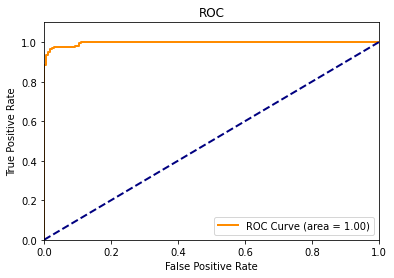

In [ ]:
plt.figure()
lw = 2
plt.plot(
    false_pos_rate,
    true_pos_rate,
    color='darkorange',
    lw=lw,
    label='ROC Curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylim([0.0, 1.1])
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

# Use Model to Make Predictions

In [ ]:
train_generator.class_indices

{'braces': 0, 'no_braces': 1}

In [ ]:
def predictImage(filename):
    img1 = load_img(filename,target_size=resize_dim)
    plt.figure()
    plt.imshow(img1)
 
    Y = img_to_array(img1)
    
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
    print(val)
    if val >= 0.5:
        # print('No Braces')
        plt.xlabel("No Braces",fontsize=30)
        
    
    elif val < 0.5:
        # print('Braces')
        plt.xlabel("Braces",fontsize=30)

1/1 [==============================] - 0s 188ms/step
[[0.]]
1/1 [==============================] - 0s 15ms/step
[[0.]]
1/1 [==============================] - 0s 17ms/step
[[0.]]
1/1 [==============================] - 0s 19ms/step
[[0.]]
1/1 [==============================] - 0s 15ms/step
[[0.]]
1/1 [==============================] - 0s 15ms/step
[[0.]]
1/1 [==============================] - 0s 15ms/step
[[0.]]
1/1 [==============================] - 0s 18ms/step
[[0.]]
1/1 [==============================] - 0s 15ms/step
[[0.]]
1/1 [==============================] - 0s 17ms/step
[[0.]]


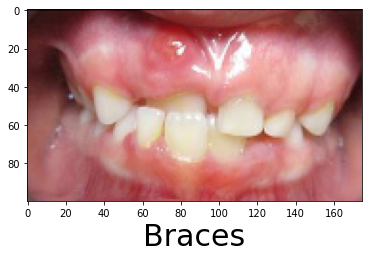

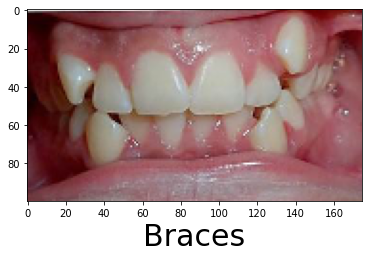

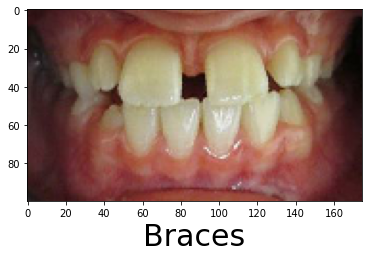

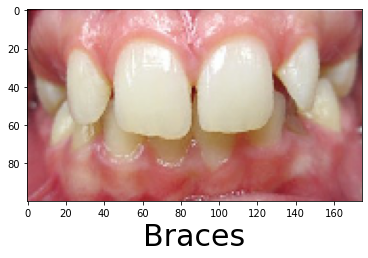

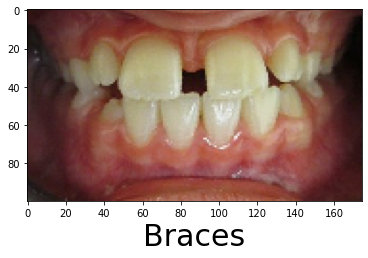

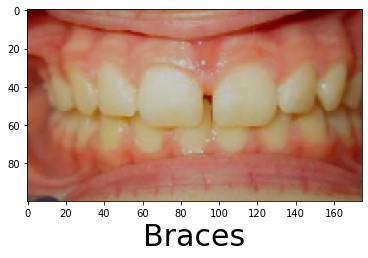

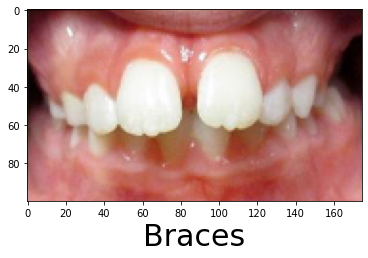

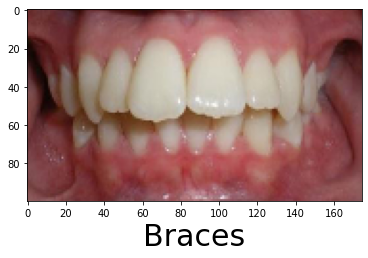

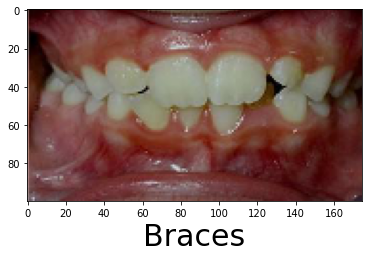

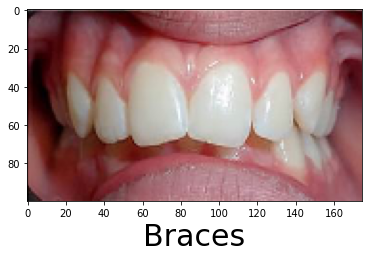

In [ ]:
test_braces_imgs = random.sample(os.listdir(braces_validation_dirpath), 10)
for fname in test_braces_imgs:
  fpath = os.path.join(braces_validation_dirpath, fname)
  predictImage(fpath)

1/1 [==============================] - 0s 17ms/step
[[1.5832082e-38]]
1/1 [==============================] - 0s 16ms/step
[[1.]]
1/1 [==============================] - 0s 19ms/step
[[1.]]
1/1 [==============================] - 0s 18ms/step
[[1.]]
1/1 [==============================] - 0s 15ms/step
[[1.]]
1/1 [==============================] - 0s 18ms/step
[[1.]]
1/1 [==============================] - 0s 19ms/step
[[1.]]
1/1 [==============================] - 0s 18ms/step
[[1.]]
1/1 [==============================] - 0s 16ms/step
[[1.]]
1/1 [==============================] - 0s 18ms/step
[[1.]]


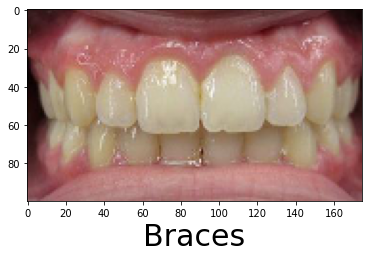

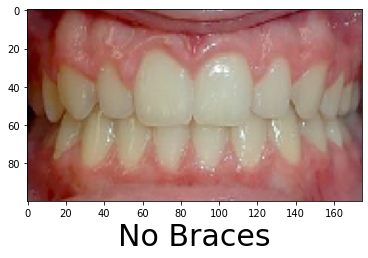

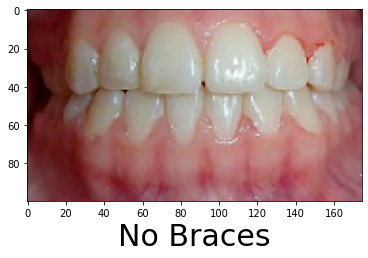

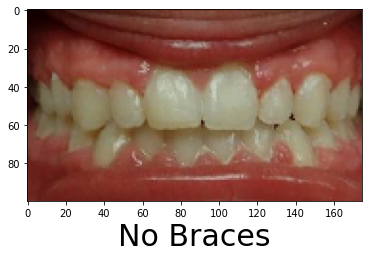

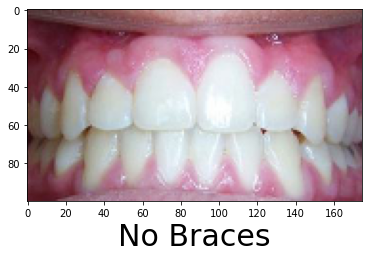

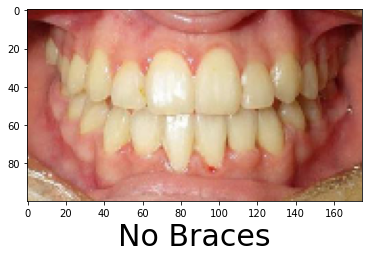

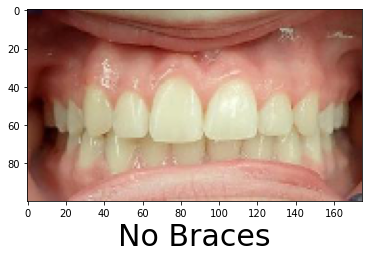

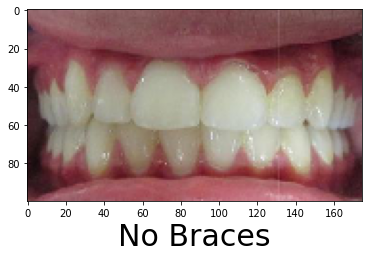

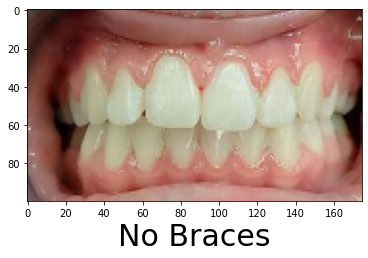

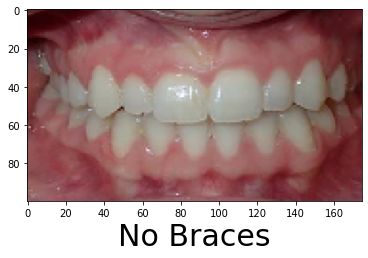

In [ ]:
test_no_braces_imgs = random.sample(os.listdir(no_braces_validation_dirpath), 10)
for fname in test_no_braces_imgs:
  fpath = os.path.join(no_braces_validation_dirpath, fname)
  predictImage(fpath)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 173, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 86, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 84, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 42, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 40, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 20, 128)      0

# Test Predictions

In [ ]:
test_zip_fname: str = 'test.zip'
test_zip_fpath = os.path.join(DATA_DIR, test_zip_fname)

# extract training files from zip
zip_ref = zipfile.ZipFile(test_zip_fpath)
zip_ref.extractall('data')
test_dirpath = 'data/test'
test_braces_dirpath = os.path.join(test_dirpath, 'braces')
test_no_braces_dirpath = os.path.join(test_dirpath, 'no_braces')

test_braces_fnames = os.listdir(test_braces_dirpath)
test_no_braces_fnames = os.listdir(test_no_braces_dirpath)

# print(f'braces fnames: {sorted(test_braces_fnames)[:10]}')
# print('\n')
# print(f'no braces fnames: {sorted(test_no_braces_fnames)[:10]}')

NameError: ignored

In [ ]:
test_dirpath = 'data/test'
test_braces_dirpath = os.path.join(test_dirpath, 'braces')
test_no_braces_dirpath = os.path.join(test_dirpath, 'no_braces')

1/1 [==============================] - 0s 15ms/step
[[0.]]
1/1 [==============================] - 0s 17ms/step
[[0.]]
1/1 [==============================] - 0s 18ms/step
[[0.]]


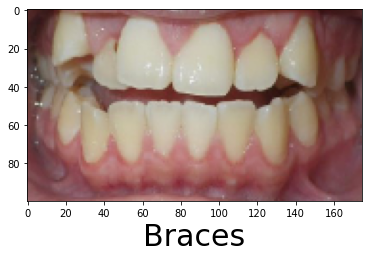

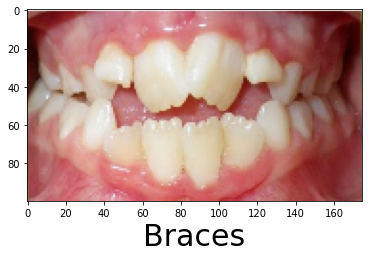

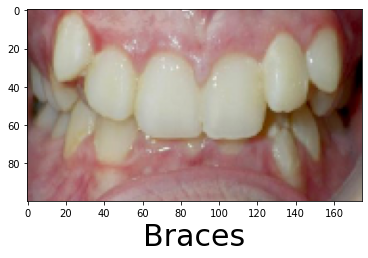

In [ ]:
for fname in test_braces_fnames:
  fpath = os.path.join(test_braces_dirpath, fname)
  predictImage(fpath)

1/1 [==============================] - 0s 28ms/step
[[0.]]
1/1 [==============================] - 0s 15ms/step
[[1.]]
1/1 [==============================] - 0s 14ms/step
[[1.]]


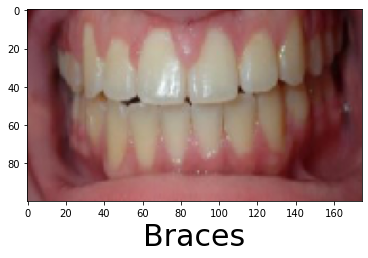

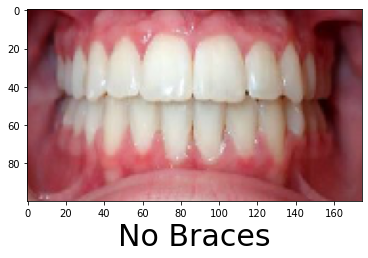

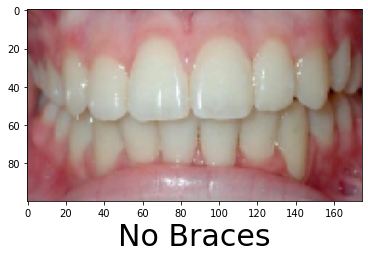

In [ ]:
for fname in test_no_braces_fnames:
  fpath = os.path.join(test_no_braces_dirpath, fname)
  predictImage(fpath)

# Save Model

In [ ]:
def get_model_dirname() -> str:
  today: str = datetime.now().date().strftime('%Y-%m-%d')
  save_model_dirname = f'{today}_cnn-model'
  return save_model_dirname
  
def save_model(model, location: str = MODEL_DIR, model_dirname_override: str = None):
  
  if model_dirname_override:
    save_model_dirname = model_dirname_override
  else:
    save_model_dirname = get_model_dirname()
  
  save_model_path = os.path.join(location, save_model_dirname)
  
  model.save(save_model_path, save_format='tf')
  return

In [ ]:
save_model(model)

# Load Model

In [ ]:
def get_latest_model_path():
  models = os.listdir(MODEL_DIR)
  sorted_models = sorted(
      models,
      key=lambda dirname: datetime.strptime(
          re.match(r'([0-9]{4}-[0-9]{1,2}-[0-9]{1,2})_', dirname).groups()[0],
          '%Y-%m-%d'))
  sorted_models = [d for d in sorted_models if d]

  return os.path.join(MODEL_DIR, sorted_models[-1]) if sorted_models else None

In [ ]:
saved_model_path = get_latest_model_path()
new_model = tf.keras.models.load_model(saved_model_path)

In [ ]:
saved_model_path

'/content/drive/MyDrive/nyu_stern/fall_2022/FDN_NTWK_MBL_SYS/Project Smile/Project Smile/project-smile/models/2022-12-12_cnn-model'

In [ ]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 173, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 86, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 84, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 42, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 40, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 20, 128)      0

In [ ]:
# loss, acc = new_model.evaluate(validation_generator)

In [ ]:
# print('restored model, accuracy: {:5.2f}%'.format(100*acc))

# Deploy Model to GCP

In [ ]:
auth.authenticate_user()

In [ ]:
CLOUD_PROJECT: str = 'ninth-park-362413'
BUCKET: str = 'gs://' + CLOUD_PROJECT + '-tf2-models'

In [ ]:
BUCKET

'gs://ninth-park-362413-tf2-models'

In [ ]:
# configure gcloud with the project
!gcloud config set project $CLOUD_PROJECT

Updated property [core/project].


In [ ]:
# create a cloud storage bucket and print the GCS bucket URL
!gsutil mb $BUCKET
print(BUCKET)

Creating gs://ninth-park-362413-tf2-models/...
ServiceException: 409 A Cloud Storage bucket named 'ninth-park-362413-tf2-models' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.
gs://ninth-park-362413-tf2-models


In [ ]:
# save the model to the bucket
save_model(model, BUCKET)

In [ ]:
MODEL: str = 'smile_cnn'

In [ ]:
# create the model
!gcloud ai-platform models create $MODEL --regions=us-east4

Using endpoint [https://ml.googleapis.com/]
Created ai platform model [projects/ninth-park-362413/models/smile_cnn].


In [ ]:
VERSION: str = 'v1'
GCP_MODEL_DIR = BUCKET + '/' + get_model_dirname()

In [ ]:
GCP_MODEL_DIR

'gs://ninth-park-362413-tf2-models/2022-12-12_cnn-model'

In [ ]:
!gcloud ai-platform models list --region='global'

Using endpoint [https://ml.googleapis.com/]
NAME       DEFAULT_VERSION_NAME
smile_cnn


In [ ]:
# deploy the model
!gcloud ai-platform versions create $VERSION \
  --model $MODEL \
  --origin $GCP_MODEL_DIR \
  --runtime-version=2.1 \
  --framework='tensorflow' \
  --python-version=3.7 \
  --region='global'

Using endpoint [https://ml.googleapis.com/]


# Test API Model Predictions

In [12]:
# general imports
import cv2
from datetime import datetime
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import re
import shutil
import zipfile
import matplotlib.image as mpimg

# google colab imports
from google.colab import drive
from google.colab import auth

# tensorflow imports
from itertools import cycle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from keras import callbacks
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
import googleapiclient.discovery

In [2]:
# Globals
DRIVE_MOUNT_DIR: str = '/content/drive'
PROJECT_DIR: str = os.path.join(DRIVE_MOUNT_DIR, 'MyDrive/nyu_stern/fall_2022/FDN_NTWK_MBL_SYS/Project Smile/Project Smile/project-smile')
DATA_DIR: str = os.path.join(PROJECT_DIR, 'data')
MODEL_DIR: str = os.path.join(PROJECT_DIR, 'models')
CLOUD_PROJECT: str = 'ninth-park-362413'
BUCKET: str = 'gs://' + CLOUD_PROJECT + '-tf2-models'
MODEL: str = 'smile_cnn'

In [3]:
drive.mount(DRIVE_MOUNT_DIR)

Mounted at /content/drive


In [4]:
auth.authenticate_user()

In [5]:
!gcloud config set project $CLOUD_PROJECT

Updated property [core/project].


In [6]:
test_zip_fname: str = 'test.zip'
test_zip_fpath = os.path.join(DATA_DIR, test_zip_fname)

# extract training files from zip
zip_ref = zipfile.ZipFile(test_zip_fpath)
zip_ref.extractall('data')
test_dirpath = 'data/test'
test_braces_dirpath = os.path.join(test_dirpath, 'braces')
test_no_braces_dirpath = os.path.join(test_dirpath, 'no_braces')

test_braces_fnames = os.listdir(test_braces_dirpath)
test_no_braces_fnames = os.listdir(test_no_braces_dirpath)

In [7]:
def predict_json(project, model, instances, image, version=None):
  service = googleapiclient.discovery.build('ml', 'v1')
  name = 'projects/{}/models/{}'.format(project, model)

  if version is not None:
      name += '/versions/{}'.format(version)

  response = service.projects().predict(
      name=name,
      body={'instances': instances}
  ).execute()

  if 'error' in response:
      raise RuntimeError(response['error'])

  plt.figure()
  plt.imshow(image)
  pred = response['predictions'][0]['dense_1'][0]
  if pred >= 0.5:
    plt.xlabel("No Braces Needed!",fontsize=30)
    
  elif pred < 0.5:
    plt.xlabel("You Need Braces :(",fontsize=30)

  return

In [8]:
# set resize dimensions
resize_height = 100
resize_width = 175

resize_dim = (resize_height, resize_width)

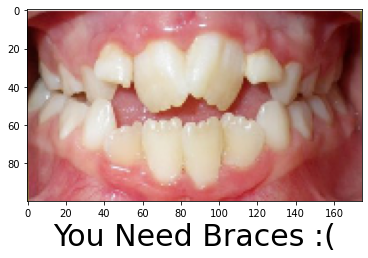

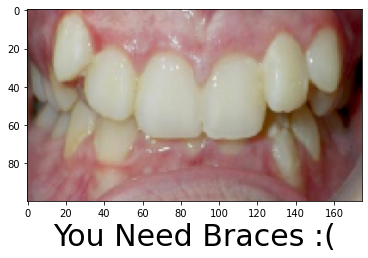

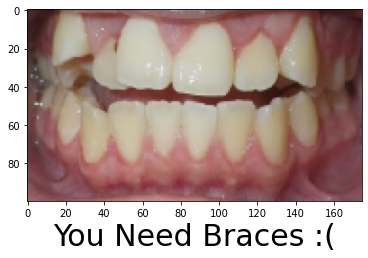

In [10]:
for i in test_braces_fnames:
  predict_braces_img = os.path.join(test_braces_dirpath, i)
  img = load_img(predict_braces_img ,target_size=resize_dim)
  img_arr = img_to_array(img)
  predict_json(CLOUD_PROJECT, MODEL, [img_arr.tolist()], img)

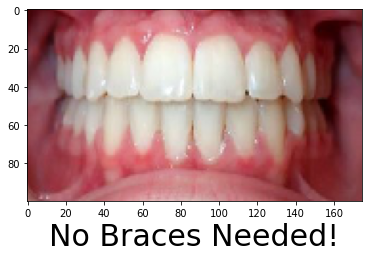

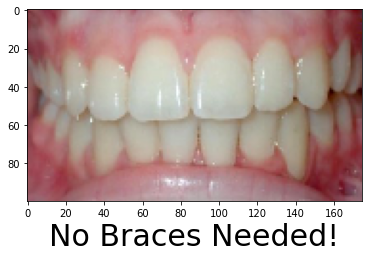

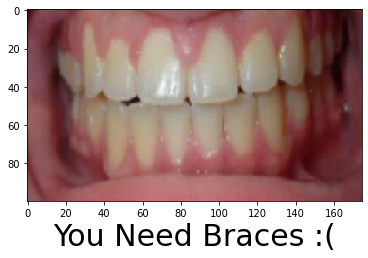

In [11]:
for i in test_braces_fnames:
  predict_braces_img = os.path.join(test_no_braces_dirpath, i)
  img = load_img(predict_braces_img ,target_size=resize_dim)
  img_arr = img_to_array(img)
  predict_json(CLOUD_PROJECT, MODEL, [img_arr.tolist()], img)